In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import imageio.v2 as imageio
from tqdm import tqdm

%matplotlib inline

In [3]:
m1 = torch.tensor([4, -4., 0])
m2 = torch.tensor([0., 0., -4.])
t = .1
dt = 0.01
sigma = 3.
min_val = -6
max_val = 6

In [4]:
def calc_logsumexp(x, denom):
    return torch.exp(x - torch.logsumexp(denom, dim=0))


def uncond_score(x, t, m1, m2, Gamma_t, label=None, omega=None):
    exp_neg_t = torch.exp(-t)
    exp_neg_m1m2 = torch.exp(-m1 * m2 * exp_neg_t**2 / Gamma_t)
    exp_pos_m1m2 = torch.exp(m1 * m2 * exp_neg_t**2 / Gamma_t)
    x_dot_m1_plus_m2 = torch.dot(x, (m1 + m2))
    x_dot_m1_minus_m2 = torch.dot(x, (m1 - m2))

    arg1 = torch.log(exp_neg_m1m2) + x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg2 = torch.log(exp_neg_m1m2) - x_dot_m1_plus_m2 * exp_neg_t / Gamma_t
    arg3 = torch.log(exp_pos_m1m2) + x_dot_m1_minus_m2 * exp_neg_t / Gamma_t
    arg4 = torch.log(exp_pos_m1m2) - x_dot_m1_minus_m2 * exp_neg_t / Gamma_t

    denom = torch.stack([arg1, arg2, arg3, arg4], dim=0)
    l11 = (m1 + m2) * calc_logsumexp(arg1, denom)
    l12 = -(m1 + m2) * calc_logsumexp(arg2, denom)
    l21 = (m1 - m2) * calc_logsumexp(arg3, denom)
    l22 = - (m1 - m2) * calc_logsumexp(arg4, denom)

    S_i_t = (-x / Gamma_t) + (exp_neg_t / Gamma_t) * (l11 + l12 + l21 + l22)
    return S_i_t


def cond_score(x, t, m1, m2, Gamma_t, label=0, omega=None):
    score = (-x + ((2*(label < 2)-1) * m1 + (2*(label % 2)-1) * m2)
             * torch.exp(-t)) / Gamma_t
    return score


def cfg(x, t, m1, m2, Gamma_t, omega, label=0):
    uncond_score_ = uncond_score(x, t, m1, m2, Gamma_t, label)
    cond_score_ = cond_score(x, t, m1, m2, Gamma_t, label)
    return (1+omega) * cond_score_ - omega * uncond_score_

In [5]:
def get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=-5, max=5, label=0, plot=False, omega=None, l=0.5, elev=45, azim=45,):
    t, sigma = torch.tensor(t), torch.tensor(sigma)
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    xx, yy, zz = torch.meshgrid(
        [torch.linspace(min, max, steps=n)]*3, indexing='ij')
    inp = torch.stack((xx, yy, zz), dim=-1).reshape(-1, 3)
    conc = []
    for inp_ in inp:
        conc.append(score_func(inp_, t, m1, m2, Gamma_t, label=label, omega=omega))

    conc = torch.stack(conc).detach().numpy()
    inp = inp.detach().numpy()

    if plot:
        ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
        ax.quiver(inp[:, 0], inp[:, 1], inp[:, 2], conc[:, 0],
                  conc[:, 1], conc[:, 2], length=l, normalize=True, alpha=0.5)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)
        ax.view_init(elev=elev, azim=azim)
        plt.suptitle("Time is t: "+str(round(t.item(), 2)))
        plt.tight_layout()
        plt.show()
    return inp, conc

In [6]:
def generate_gif(gifname, score_func, m1, m2, dt, sigma, min_val, max_val, label=None, omega=None, l=.75,  elev=45, azim=45,):
    images = []

    t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
    for t_value in tqdm(t_values):
        t = torch.tensor([t_value])
        inp, conc = get_vf(m1, m2, score_func, t, dt, sigma, n=10, min=min_val, max=max_val, label=label, omega=omega, l=l, elev=elev, azim=azim,)

        ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
        ax.quiver(inp[:,0], inp[:,1], inp[:,2], conc[:,0],conc[:,1], conc[:,2], length=.75, normalize=True, alpha=0.5)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)
        ax.view_init(elev=30, azim=25)  
        plt.title(f't = {t_value:.2f}')
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.tight_layout()

        plt_path = f'temp_plots/temp_{t_value:.2f}.png'
        plt.savefig(plt_path)
        plt.close()
        

        images.append(imageio.imread(plt_path))

    imageio.mimsave('gifs/'+gifname+'.gif', images, duration=0.05)

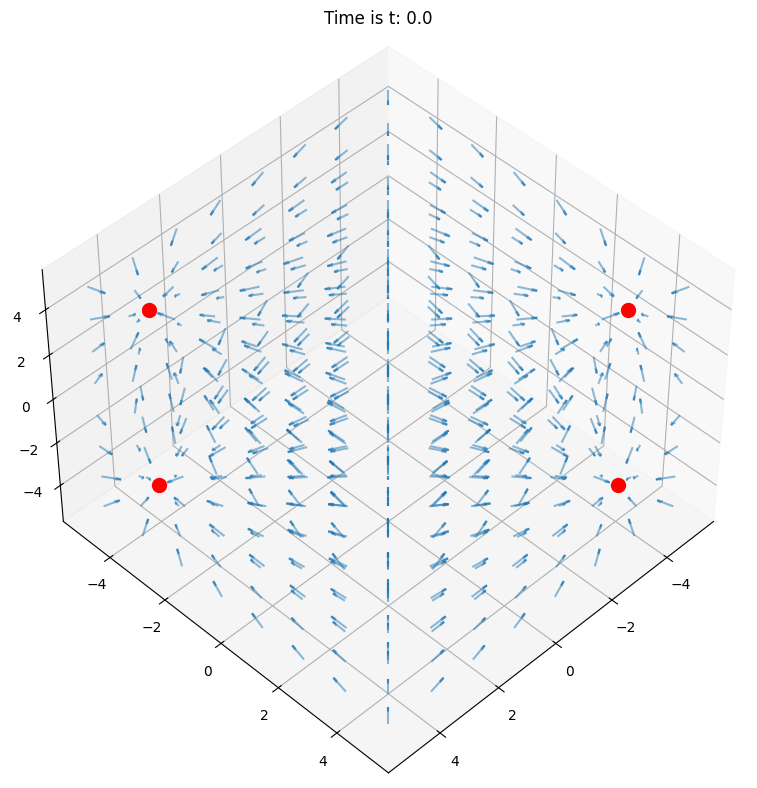

In [7]:
inp, conc = get_vf(m1, m2, uncond_score, t=0.0, dt=0.01, sigma=1., n=8, min=-5, max=5, plot=True)

In [ ]:
generate_gif('uncond_score_3d', uncond_score, m1, m2, dt, sigma, min_val, max_val, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


## Only CFG part (true score)

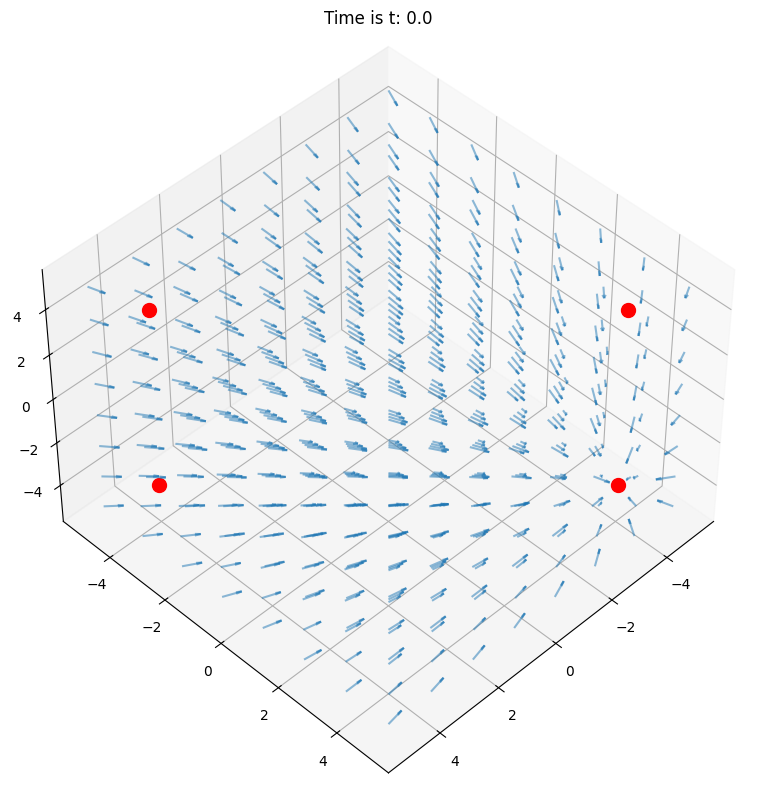

In [7]:
inp, conc = get_vf(m1, m2, cond_score, t=0.0, dt=0.01, sigma=1., n=8, min=-5, max=5, plot=True, label=3)

In [ ]:
generate_gif('cond_score_3d', cond_score, m1, m2, dt, sigma, min_val, max_val, label=0, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


# CFG

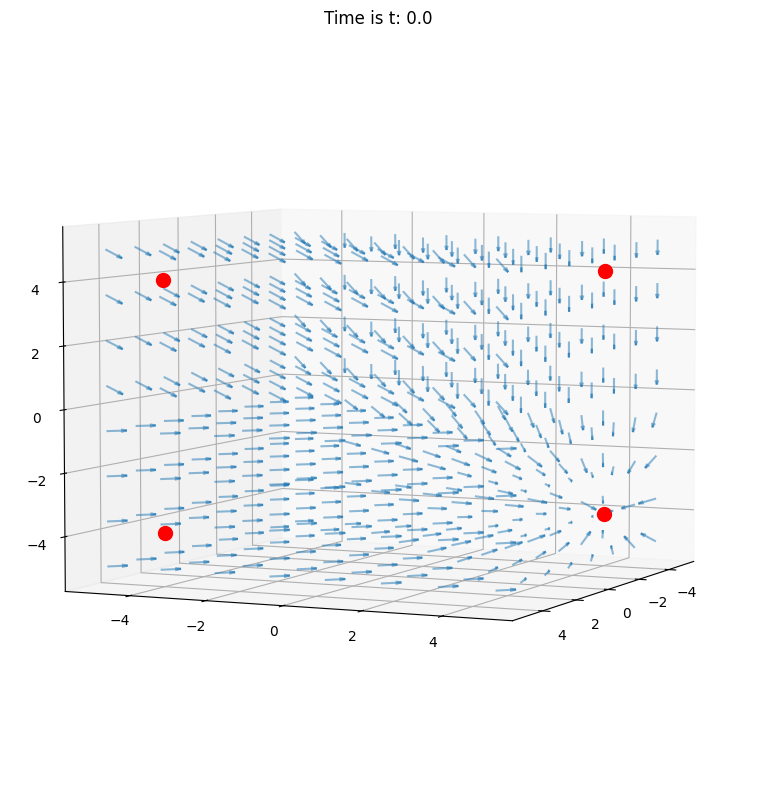

In [8]:
inp, conc = get_vf(m1, m2, cfg, t=0.0, dt=0.01, sigma=1., omega=100, n=8, min=-5, max=5, plot=True, label=3, elev=5, azim=25)

In [ ]:
generate_gif('cfg_score_3d', cfg, m1, m2, omega=1.5, sigma=sigma, min_val=min_val, max_val=max_val, dt=dt, label=0, l=.75, elev=30, azim=25)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


# All three

In [8]:
def plot_all_three(m1, m2, t, dt, sigma, omega, n=10, min=-5, max=5, label=0, plot=False, l=0.5, elev=45, azim=45,):
    t, sigma = torch.tensor(t), torch.tensor(sigma)
    Gamma_t = sigma**2*torch.exp(-2*t) + dt
    xx, yy, zz = torch.meshgrid(
        [torch.linspace(min, max, steps=n)]*3, indexing='ij')
    inp = torch.stack((xx, yy, zz), dim=-1).reshape(-1, 3)
    conc1, conc2 = [], []
    for inp_ in inp:
        conc1.append(cond_score(inp_, t, m1, m2, Gamma_t, label))
        conc2.append(uncond_score(inp_, t, m1, m2, Gamma_t))
    conc1 = torch.stack(conc1).detach().numpy()
    conc2 = torch.stack(conc2).detach().numpy()
    conc = (1 + omega) * conc1 - omega * conc2
    inp = inp.detach().numpy()
    
    if plot:
        fig = plt.figure(figsize=(18, 6))

        for i, c in enumerate([conc1, conc2, conc], start=1):
            ax = fig.add_subplot(1, 3, i, projection='3d')
            ax.set_title(['Conditional vec. field', 
                        'Unconditional vec. field', 
                        'CFG vec. field'][i-1])            
            ax.quiver(inp[:, 0], inp[:, 1], inp[:, 2], c[:, 0],
                  c[:, 1], c[:, 2], length=l, normalize=True, alpha=0.5)
            for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
                ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)

            ax.view_init(elev=elev, azim=azim)
        plt.suptitle("$t=$"+str(round(t.item(), 2))+f", $\omega=$"+str(omega), y=1.01)
        plt.tight_layout()
        plt.show()
    return inp, conc1, conc2, conc

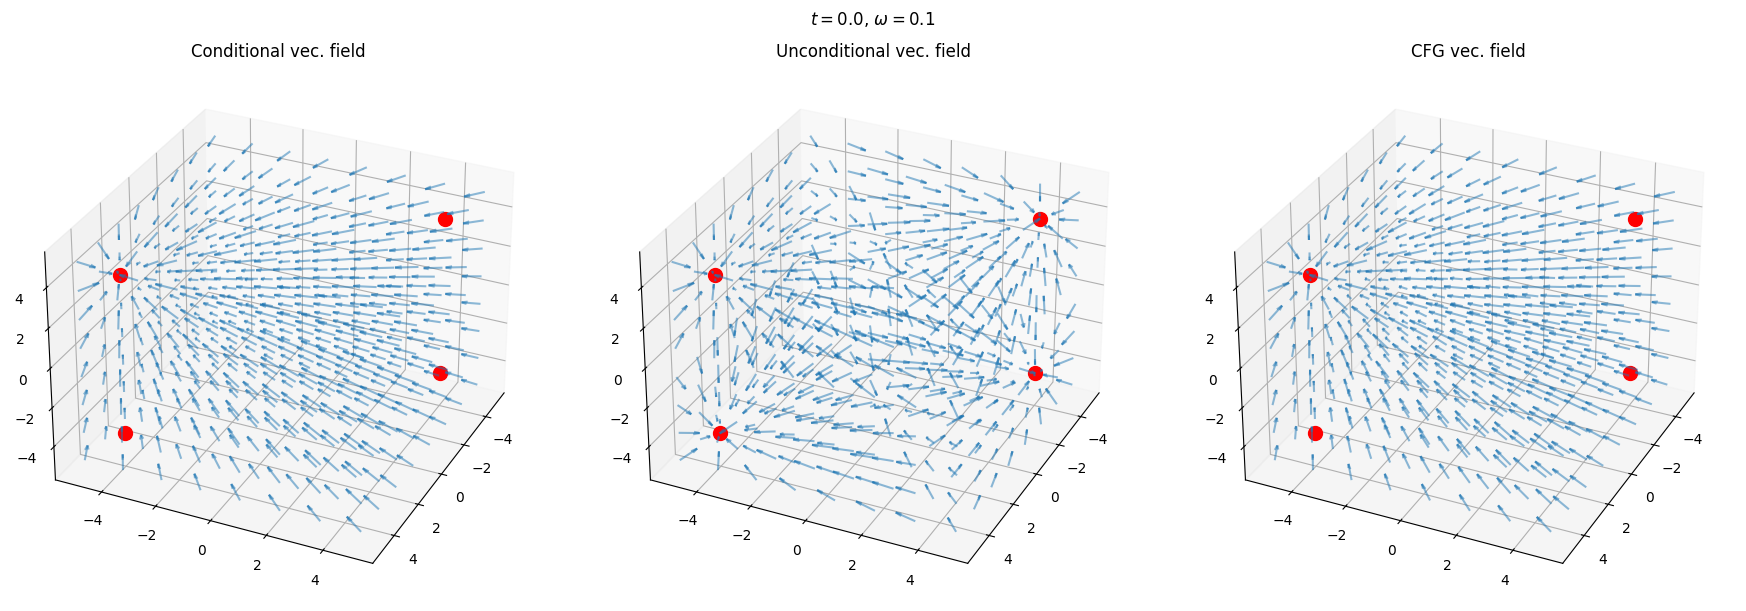

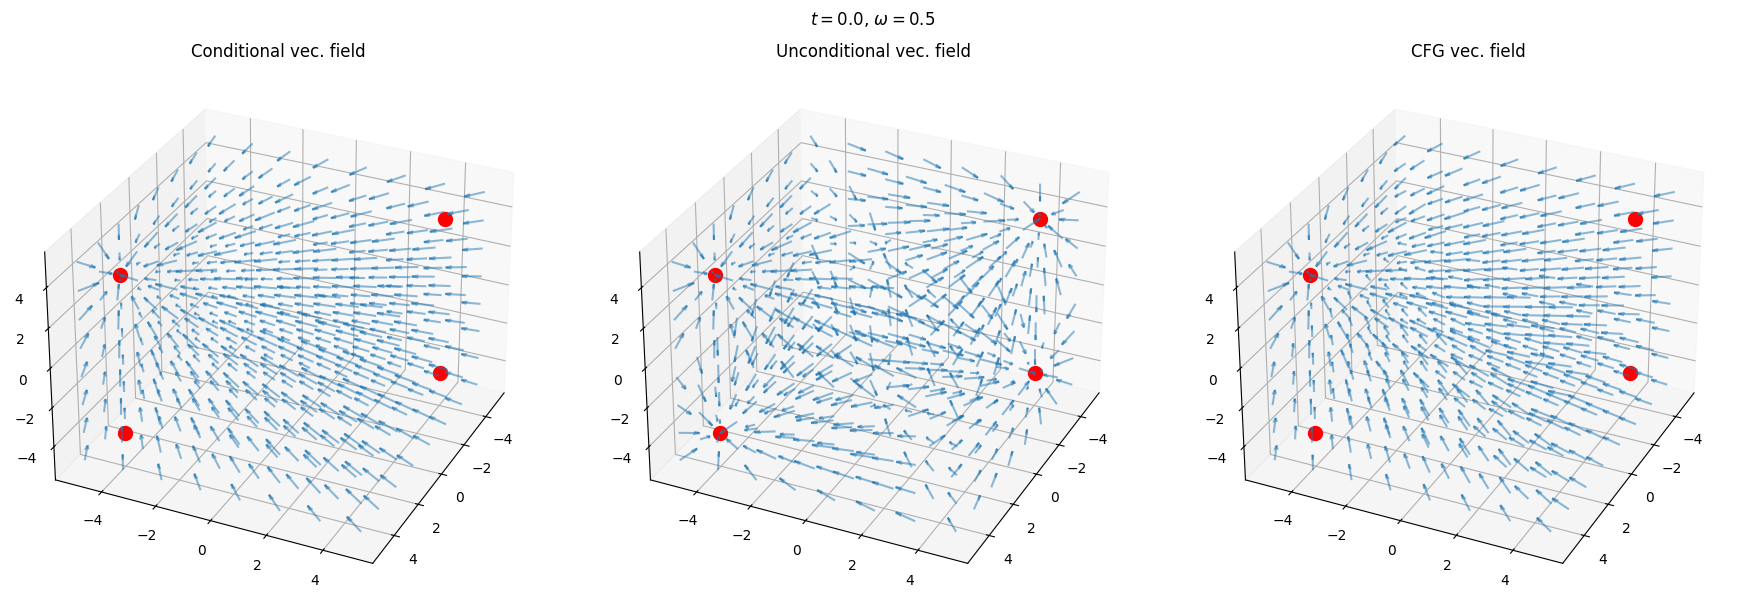

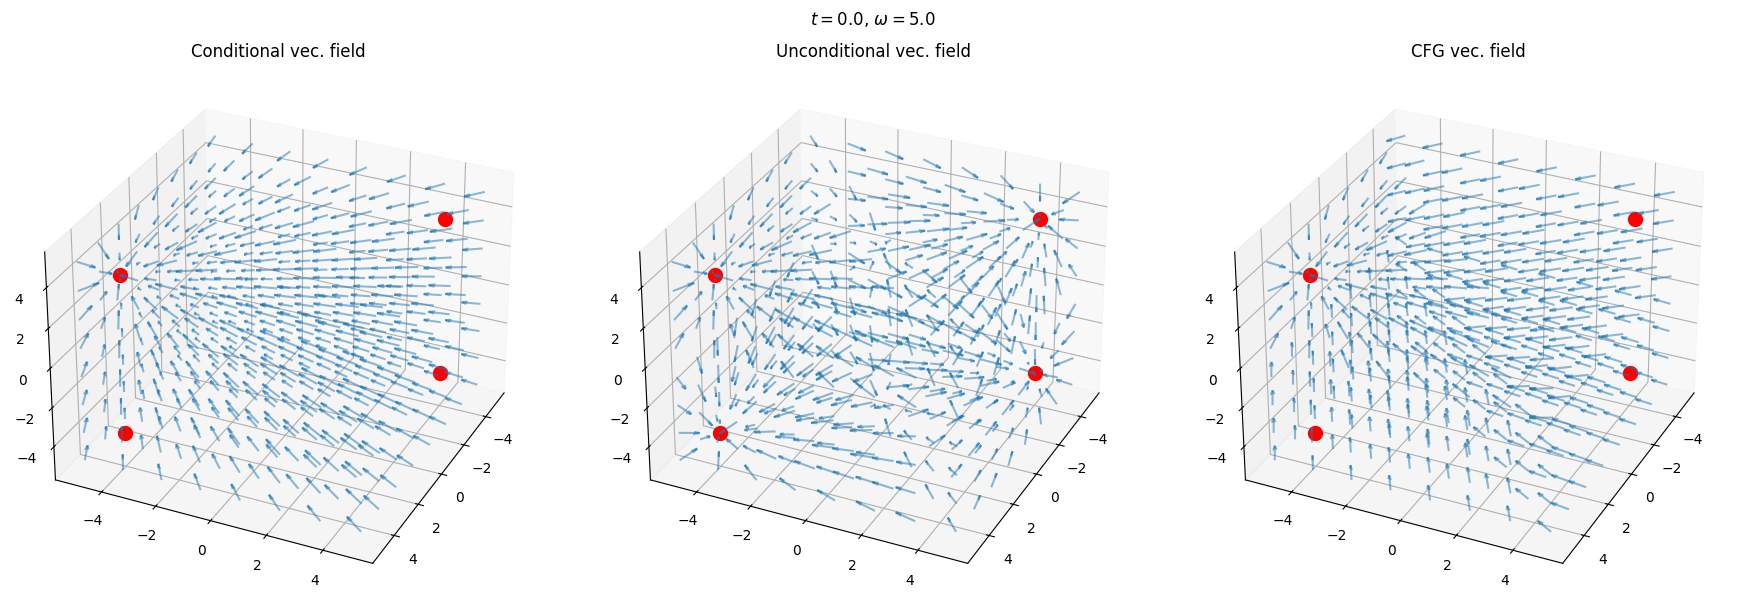

In [9]:
t = 0.
sigma = 1.
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=0.1, n=8, min=-5, max=5, plot=True, l=.75, elev=30, azim=25)
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=0.5, n=8, min=-5, max=5, plot=True, l=.75, elev=30, azim=25)
_, _, _, _= plot_all_three(m1, m2, t, dt, sigma, omega=5.0, n=8, min=-5, max=5, plot=True, l=.75, elev=30, azim=25)

In [16]:
omega = .5
images = []
elev, azim, l = 30, 25, .75


t_values = torch.flip(torch.linspace(0,2., steps=100),dims=[0])
for t_value in tqdm(t_values):
    t = torch.tensor([t_value])
    inp, conc1, conc2, conc = plot_all_three(m1, m2, t, dt, sigma, omega=omega, n=8, min=min_val, max=max_val)
    # Plot the function
    fig = plt.figure(figsize=(18*1.4, 6*1.4))
    fig.subplots_adjust(top=0.85)  # Add some padding at the top

    for i, c in enumerate([conc1, conc2, conc], start=1):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.set_title(['Conditional vec. field', 
                    'Unconditional vec. field', 
                    'CFG vec. field'][i-1])            
        ax.quiver(inp[:, 0], inp[:, 1], inp[:, 2], c[:, 0],
                c[:, 1], c[:, 2], length=l, normalize=True, alpha=0.5)
        for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
            ax.scatter(plots[0], plots[1], plots[2], color='black', s=25)
        
        ax.view_init(elev=elev, azim=azim)
    # Save the plot to a temporary file
    plt_path = f'temp_plots/temp_{t_value:.2f}.png'
    plt.suptitle("$t=$"+str(round(t.item(), 2))+f", $\omega=$"+str(omega), y=0.95)
    plt.tight_layout()
    plt.savefig(plt_path)
    plt.close()
    
    # Append the image to the list
    images.append(imageio.imread(plt_path))
# Create a GIF
imageio.mimsave('gifs/combined_3d_w'+str(omega)+'.gif', images, duration=0.05)

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_301624/1454574611.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t, sigma = torch.tensor(t), torch.tensor(sigma)
100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


# Forward ODE

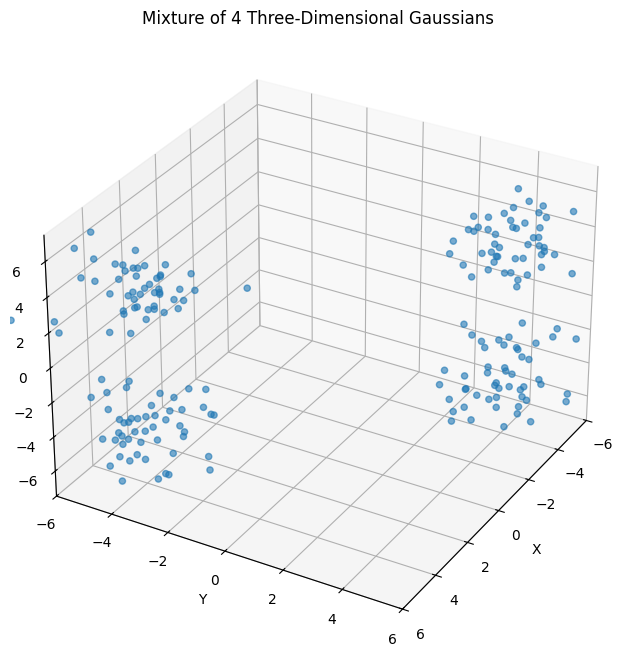

In [27]:
sigma = 1.

means = torch.stack([m1+m2, m1-m2,-m1+m2,-m1-m2])
covariances = torch.tensor([[[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]] * 4) * sigma
weights = torch.tensor([0.25, 0.25, 0.25, 0.25]) 
num_samples = 200
samples = []
for mean, cov, weight in zip(means, covariances, weights):
    num_samples_gaussian = int(num_samples * weight)
    distribution = torch.distributions.MultivariateNormal(mean, cov)
    samples_gaussian = distribution.sample((num_samples_gaussian,))
    samples.append(samples_gaussian)

all_samples = torch.cat(samples)

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), all_samples[:, 2].numpy(), alpha=0.6)
ax.view_init(elev=30, azim=30)

plt.title('Mixture of 4 Three-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()


In [28]:
finish_time = 4.
num_iter = 200

images_new, x_prev = [], all_samples

for t_ in tqdm(torch.linspace(0., finish_time, steps=num_iter)):
    t_ = torch.tensor([t_])
    x_cur = []
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*t_) + dt
        score = uncond_score(x, t_, m1, m2, Gamma_t)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    x_prev = x_cur
    
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    ax.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(),x_cur[:,2].detach().numpy(), alpha=0.6)
    ax.view_init(elev=30, azim=30)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_zlim(min_val, max_val)
    
    plt.title("Time is t: "+str(round(t_.item(),2)))
    plt_path = f'temp_plots/temp_{t_.item():.2f}.png'
    
    plt.savefig(plt_path)
    plt.close()
    
    images_new.append(imageio.imread(plt_path))
    

imageio.mimsave('gifs/forward_3d.gif', images_new, fps=10)

100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


# Reverse ODE

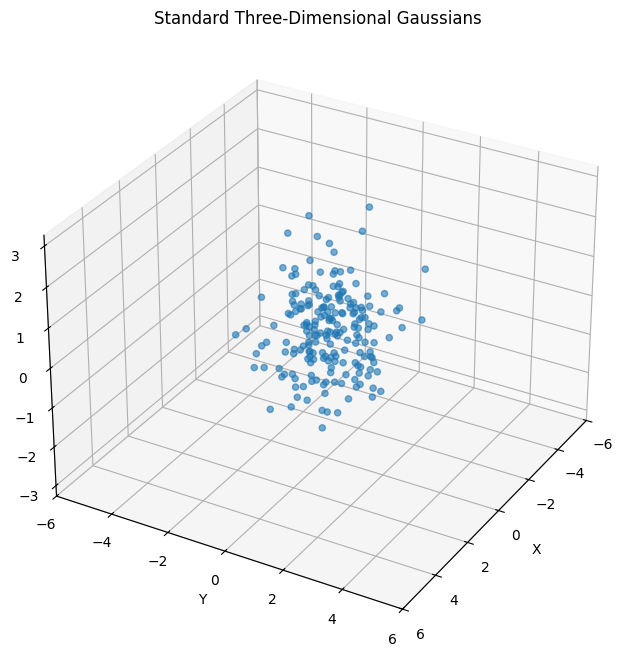

In [29]:
num_samples = 200
mean, cov = torch.tensor([0., 0., 0.]), torch.tensor([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]])
distribution = torch.distributions.MultivariateNormal(mean, cov)
all_samples = distribution.sample((num_samples,))

ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
ax.scatter(all_samples[:, 0].numpy(), all_samples[:, 1].numpy(), all_samples[:, 2].numpy(), alpha=0.6)
ax.view_init(elev=30, azim=30)

plt.title('Standard Three-Dimensional Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.grid(True)
plt.show()


In [31]:
sigma = .2
dt = 0.01
finish_time = 4.
num_iter = 200

images_new, x_prev = [], all_samples

timesteps = torch.tensor(np.arange(0, finish_time+dt, dt))
for t in tqdm(timesteps):
    t_end = torch.tensor(finish_time)
    x_cur = []
    
    for x in x_prev:
        Gamma_t = sigma**2*torch.exp(-2*(t_end-t)) + dt
        # score = uncond_score(x, t_end-t, m1, m2, Gamma_t)
        # score = cond_score(x, t_end-t, m1, m2, Gamma_t, label=0)
        score = cfg(x, t_end-t, m1, m2, Gamma_t, omega=.5, label=0)
        eta = torch.randn_like(x) * torch.sqrt(torch.tensor(2*dt))
        x_new = x + 2 * dt * score + eta
        x_cur.append(x_new)
    x_cur = torch.stack(x_cur)
    x_prev = x_cur
    
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    ax.scatter(x_cur[:,0].detach().numpy(), x_cur[:,1].detach().numpy(),x_cur[:,2].detach().numpy(), alpha=0.6)
    ax.view_init(elev=30, azim=30)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_zlim(min_val, max_val)
    for plots in [m1+m2, m1-m2, -m1+m2, -m1-m2]:
        ax.scatter(plots[0], plots[1], plots[2], color='r', s=100)
    
    plt.title("Time is t: "+str(round((t_end-t).item(),2)))
    plt_path = f'temp_plots/temp_{t.item():.2f}.png'
    
    plt.savefig(plt_path)
    plt.close()
    
    images_new.append(imageio.imread(plt_path))
    

imageio.mimsave('gifs/backward_3d.gif', images_new, fps=10)

100%|██████████| 401/401 [02:07<00:00,  3.15it/s]
